In [2]:
import pandas as pd
import numpy as np

import seaborn as sns #For heatmap
import matplotlib.pyplot as plt
import pandas.util.testing as tm #For heatmap
 

import scipy.cluster.hierarchy as spc #For Dendrogram

import statsmodels.api as sm #Log Reg
import statsmodels.formula.api as smf

from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score #Revérifier si tous les import de cette ligne sont utilisés
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier #For AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings

warnings.simplefilter("ignore")
np.random.seed(404)

In [3]:
df = pd.read_csv("data/whatcms_df.csv",index_col=[0])

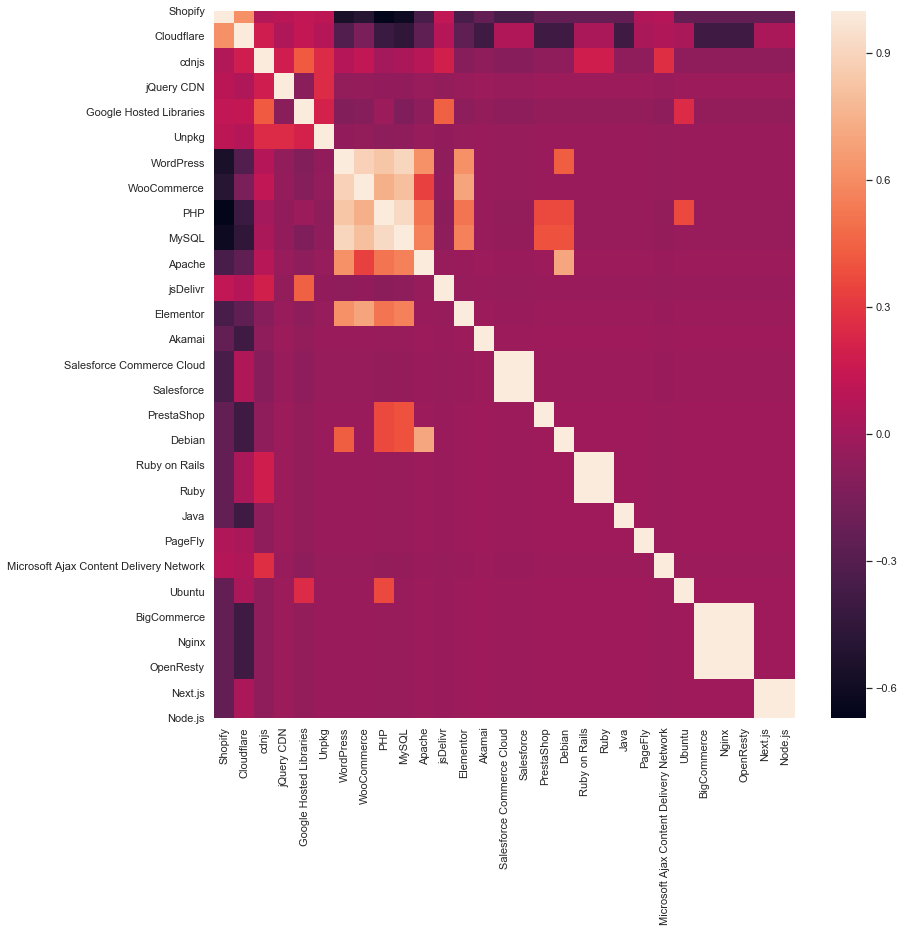

In [4]:
sns.set(rc = {'figure.figsize':(13,13)})
sns.heatmap(df.corr())

#### Some variables seem to be totally linearily correlated because one technology cannot be used without another, so we are going to get rid of the extra ones:

In [5]:
df.drop(["Ruby on Rails","Salesforce Commerce Cloud"], axis = 1, inplace = True)
df.drop(["Nginx","OpenResty","Next.js"], axis = 1, inplace = True)

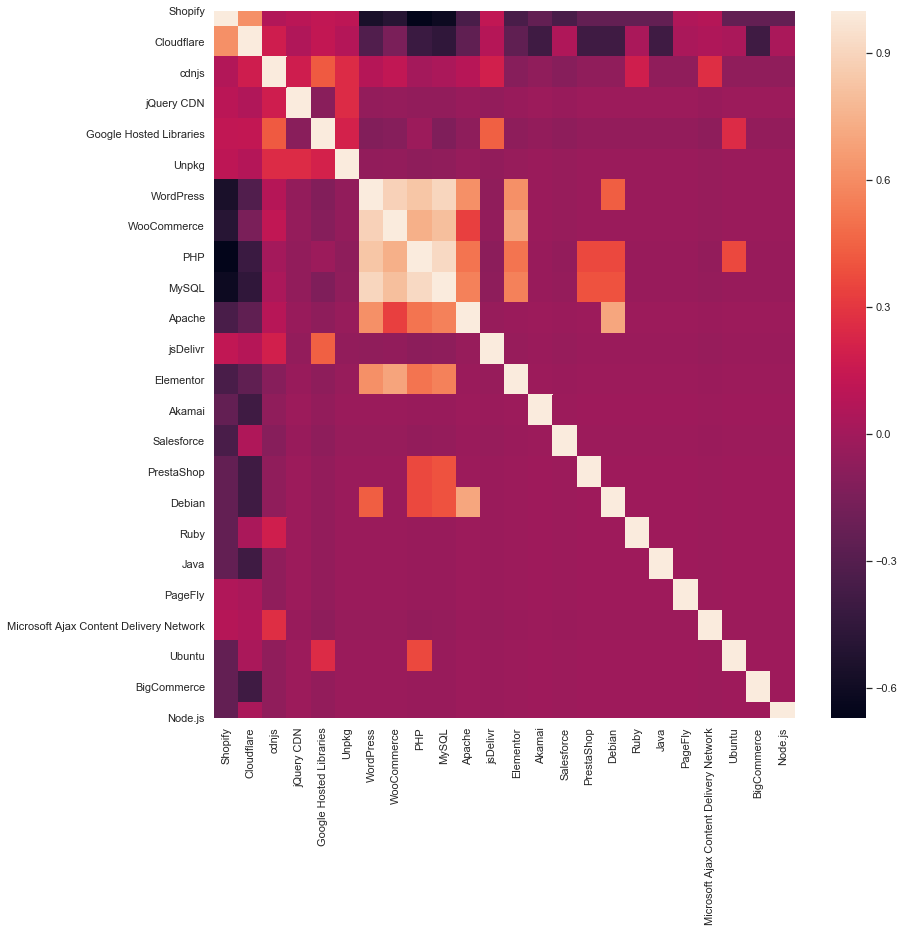

In [6]:
sns.heatmap(df.corr())

### Classification methods

### Classification

In [7]:
df.describe().iloc[1,:]

Shopify                                    0.818182
Cloudflare                                 0.922078
cdnjs                                      0.272727
jQuery CDN                                 0.038961
Google Hosted Libraries                    0.168831
Unpkg                                      0.051948
WordPress                                  0.064935
WooCommerce                                0.051948
PHP                                        0.090909
MySQL                                      0.077922
Apache                                     0.025974
jsDelivr                                   0.064935
Elementor                                  0.025974
Akamai                                     0.012987
Salesforce                                 0.025974
PrestaShop                                 0.012987
Debian                                     0.012987
Ruby                                       0.012987
Java                                       0.012987
PageFly     

In [8]:
sum(df['dropshipping?'] == 'oui')

64

In [9]:
sum(df['dropshipping?'] == 'non')

13

In [10]:
X = df.drop(["dropshipping?","URL_query"], axis = 1)
log_model = sm.OLS((df['dropshipping?'] == "oui")*1,X).fit()
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:          dropshipping?   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     3.649
Date:                Thu, 18 Aug 2022   Prob (F-statistic):           6.87e-05
Time:                        11:07:43   Log-Likelihood:                -1.5349
No. Observations:                  77   AIC:                             45.07
Df Residuals:                      56   BIC:                             94.29
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [11]:
log_model = sm.OLS((df['dropshipping?'] == "oui")*1,X.drop(['Cloudflare','Apache','Elementor','Akamai','Salesforce','Java','Microsoft Ajax Content Delivery Network','Unpkg','Ruby','PageFly','Google Hosted Libraries','WordPress','MySQL','PrestaShop'],axis = 1)).fit()
print(log_model.summary())

                                 OLS Regression Results                                
Dep. Variable:          dropshipping?   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              82.24
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                    1.23e-33
Time:                        11:07:43   Log-Likelihood:                         -2.5816
No. Observations:                  77   AIC:                                      25.16
Df Residuals:                      67   BIC:                                      48.60
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [12]:
X2 = sm.add_constant(np.array(df.drop(['dropshipping?', 'URL_query'],axis = 1)))
y2 = np.expand_dims(np.array((df['dropshipping?'] == "oui")*1),1)

X_train, X_test, y_train, y_test = train_test_split(X2,y2)

In [13]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'l1_ratio': [.001, 0.01, 0.1, 1],
             'solver' :['liblinear','saga']}


clf = GridSearchCV(LogisticRegression(penalty='l1'),
                   param_grid,
                   scoring = 'roc_auc')

clf.fit(X_train,y_train)

y_train_prediction = clf.predict(X_train)
y_test_prediction = clf.predict(X_test)

y_train_prediction_proba = clf.predict_proba(X_train)[:, 1]
y_test_prediction_proba = clf.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_train_prediction_proba)
auc_test = roc_auc_score(y_test, y_test_prediction_proba)

print('AUC the training set : ' + str(auc_train))
print('AUC for the testing set : '+ str(auc_test))



AUC the training set : 0.8418367346938775
AUC for the testing set : 0.7733333333333333


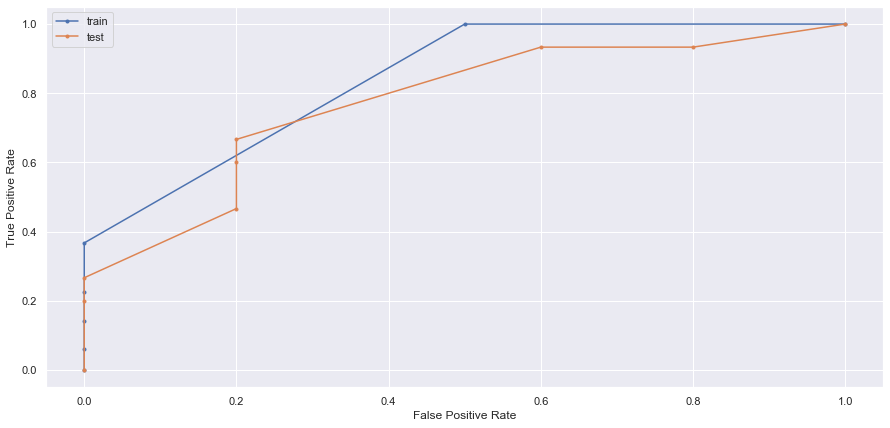

In [14]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prediction_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prediction_proba)

fig = plt.figure(figsize=(15,7))
ax = plt.plot(fpr_train, tpr_train, marker='.', label='train')
ax = plt.plot(fpr_test, tpr_test, marker='.', label='test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [15]:
clf.best_params_

{'C': 10, 'l1_ratio': 0.001, 'solver': 'liblinear'}

In [16]:
y_train_prediction = clf.predict(X_train)
y_test_prediction = clf.predict(X_test)

y_train_prediction_proba = clf.predict_proba(X_train)[:, 1]
y_test_prediction_proba = clf.predict_proba(X_test)[:, 1]

We create and fit our classifiers for the following models:

In [17]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
params_SVC = {'kernel':('linear', 'rbf'),
              'C':[1, 10]}
params_ada = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)
params_ranfor = {
    'bootstrap': [True],
    'max_depth': [2,80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

clf_log = clf
clf_gauss = GridSearchCV(GaussianNB(),
                         params_NB,
                         scoring = 'roc_auc')
clf_SVM = GridSearchCV(svm.SVC(probability = True),
                       params_SVC,
                       scoring = 'roc_auc')
clf_ada = GridSearchCV(AdaBoostClassifier(base_estimator = DTC),
                       params_ada,
                       scoring = 'roc_auc')
clf_ranfor = GridSearchCV(RandomForestClassifier(),
                          params_ranfor,
                          scoring = 'roc_auc')

In [18]:
classifiers = [clf_log,clf_gauss,clf_SVM,clf_ada,clf_ranfor]
for clf in classifiers[1:]:
    clf.fit(X_train,y_train)

# clf_ranfor.fit(X_train,y_train) #In case of bug, fit manually each model

In [19]:
def get_metrics(clf):
#     clf.fit(X_train,y_train)
    y_train_prediction = clf.predict(X_train)
    y_test_prediction = clf.predict(X_test)
    
    y_train_prediction_proba = clf.predict_proba(X_train)[:, 1]
    y_test_prediction_proba = clf.predict_proba(X_test)[:, 1]
    
    auc_train = roc_auc_score(y_train, y_train_prediction_proba)
    auc_test = roc_auc_score(y_test, y_test_prediction_proba)
    
#     print('AUC the training set : '+str(auc_train))
#     print('AUC for the testing set : '+str(auc_test))
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prediction_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prediction_proba)

#     fig = plt.figure(figsize=(15,7))
#     ax = plt.plot(fpr_train, tpr_train, marker='.', label='train')
#     ax = plt.plot(fpr_test, tpr_test, marker='.', label='test')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend()
    
    return([auc_train,auc_test,fpr_train,tpr_train,fpr_test,tpr_test])

In [20]:
models_name = ['logistic regression','Naïve Bayes','SVM','Ada Boost','Random Forest']

l = []
for x in classifiers:
    l.append(get_metrics(x))

model_perf = pd.DataFrame(data = l,
         index = models_name,
         columns = ['AUC Train','AUC Test', 'fpr train','tpr train','fpr test','tpr test'])

In [21]:
model_perf

,AUC Train,AUC Test,fpr train,tpr train,fpr test,tpr test
logistic regression,0.841837,0.773333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0]","[0.0, 0.061224489795918366, 0.1428571428571428...","[0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.6, 0.8, 1.0]","[0.0, 0.2, 0.26666666666666666, 0.466666666666..."
Naïve Bayes,0.841837,0.866667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, ...","[0.0, 0.02040816326530612, 0.04081632653061224...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, ...","[0.0, 0.06666666666666667, 0.2, 0.4, 0.5333333..."
SVM,0.790816,0.926667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, ...","[0.0, 0.02040816326530612, 0.08163265306122448...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, ...","[0.0, 0.13333333333333333, 0.2, 0.333333333333..."
Ada Boost,0.841837,0.586667,"[0.0, 0.0, 0.5, 1.0]","[0.0, 0.3673469387755102, 1.0, 1.0]","[0.0, 0.6, 0.6, 1.0]","[0.0, 0.6666666666666666, 0.9333333333333333, ..."
Random Forest,0.743622,0.886667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 0.75, 0....","[0.0, 0.061224489795918366, 0.1020408163265306...","[0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.8, ...","[0.0, 0.2, 0.26666666666666666, 0.533333333333..."


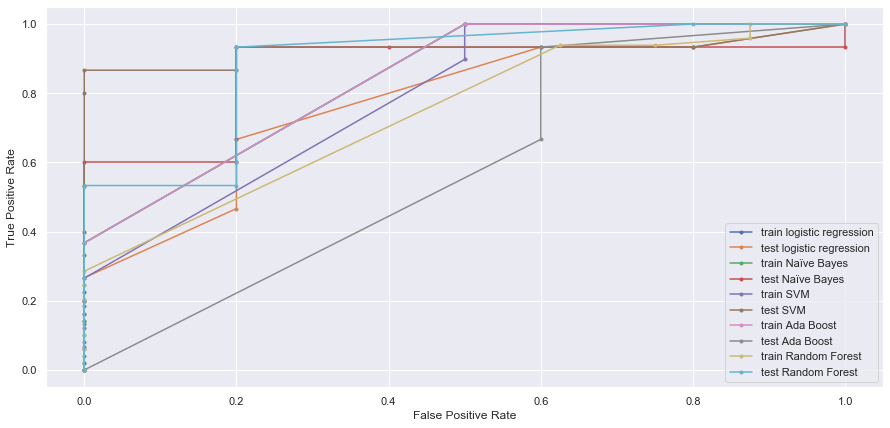

In [22]:
fig = plt.figure(figsize=(15,7))

for i in range(len(model_perf)):
    fpr_train = model_perf.iloc[i][2]
    tpr_train = model_perf.iloc[i][3]
    fpr_test = model_perf.iloc[i][4]
    tpr_test = model_perf.iloc[i][5]

    ax = plt.plot(fpr_train, tpr_train, marker='.', label='train ' + model_perf.index[i])
    ax = plt.plot(fpr_test, tpr_test, marker='.', label='test ' + model_perf.index[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [24]:
clf_SVM.best_params_

{'C': 1, 'kernel': 'rbf'}

In [23]:
model_perf.iloc[1]

AUC Train                                             0.897233
AUC Test                                              0.819444
fpr train    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.272...
tpr train    [0.0, 0.06521739130434782, 0.10869565217391304...
fpr test              [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 1.0]
tpr test     [0.0, 0.05555555555555555, 0.1111111111111111,...
Name: Naïve Bayes, dtype: object

In [24]:
model_perf

,AUC Train,AUC Test,fpr train,tpr train,fpr test,tpr test
logistic regression,0.928854,0.847222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2727272727272...","[0.0, 0.06521739130434782, 0.10869565217391304...","[0.0, 0.0, 0.0, 0.0, 0.5, 1.0]","[0.0, 0.05555555555555555, 0.16666666666666666..."
Naïve Bayes,0.897233,0.819444,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.272...","[0.0, 0.06521739130434782, 0.10869565217391304...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 1.0]","[0.0, 0.05555555555555555, 0.1111111111111111,..."
SVM,0.863636,0.819444,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2727272727272...","[0.0, 0.06521739130434782, 0.10869565217391304...","[0.0, 0.0, 0.0, 0.5, 0.5, 1.0]","[0.0, 0.1111111111111111, 0.3333333333333333, ..."
Ada Boost,0.928854,0.847222,"[0.0, 0.0, 0.2727272727272727, 1.0]","[0.0, 0.4782608695652174, 1.0, 1.0]","[0.0, 0.0, 0.5, 1.0]","[0.0, 0.3888888888888889, 1.0, 1.0]"
Random Forest,0.841897,0.819444,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27272727...","[0.0, 0.06521739130434782, 0.10869565217391304...","[0.0, 0.0, 0.0, 0.5, 0.5, 1.0]","[0.0, 0.16666666666666666, 0.3333333333333333,..."


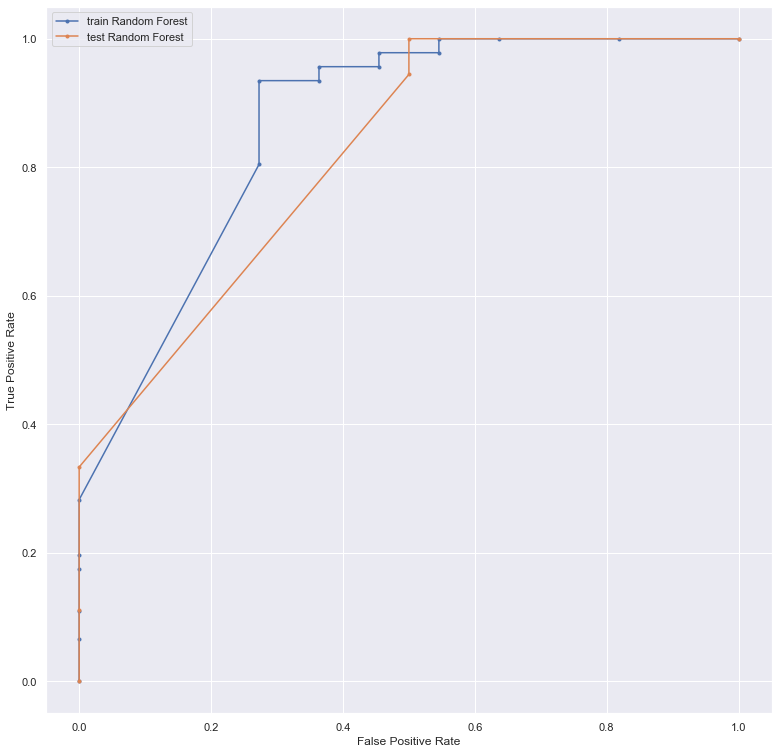

In [25]:
fpr_train = model_perf.iloc[2][2]
tpr_train = model_perf.iloc[2][3]
fpr_test = model_perf.iloc[2][4]
tpr_test = model_perf.iloc[2][5]

ax = plt.plot(fpr_train, tpr_train, marker='.', label='train ' + model_perf.index[i])
ax = plt.plot(fpr_test, tpr_test, marker='.', label='test ' + model_perf.index[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()